In [19]:
%reload_ext autoreload
%autoreload 2
import sys
import platform
import os
import uncerteval
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
%matplotlib inline
from uncerteval import StandardizerByTrainSet, DfDataProvider, CompletePoolingModel
from uncerteval import ModelFitter, get_plot_method, NoPoolingModel, MultilevelLassoModel
import numpyro
import jax.numpy as jnp
import arviz as az
from copy import deepcopy

# Applied Multilevel Models

## Ziele
- workloads
  - artificial
- pre-processing
- models
- qualitative analysis
- comparison

# Workload Artificial

Idee:
 - Workload hat
   - eine Länge
   - ein binäres Feature `mono` 
 - Software hat
   - 1 Option `lin`, deren Einfluss linear mit der Länge skaliert
   - 1 Option `const`, die WL-unabhängigen Einfluss hat
   - 1 Option `switch`, skaliert, aber keinen Einfluss hat wenn `mono`
   - 1 irrelevante Option `irr`

In [2]:
def oracle(lin, const, switch, irr, wl_length, wl_mono):
    base = wl_length
    infl_lin = 0.2 * wl_length
    infl_const = 2
    infl_switch = 0.2 * wl_length if not wl_mono else 0.0
    infl_irr = 0.01
    perf = base + infl_lin * lin + infl_const * const + infl_switch * switch + infl_irr * irr
    return perf

In [3]:
def noisy(sd_rel, x):
    return scp.stats.norm(x, sd_rel * x).rvs()

## Configurations

In [4]:
option_names = "lin", "const", "switch", "irr"
option_values = list(itertools.product([1, 0], repeat=len(option_names)))
option_values

[(1, 1, 1, 1),
 (1, 1, 1, 0),
 (1, 1, 0, 1),
 (1, 1, 0, 0),
 (1, 0, 1, 1),
 (1, 0, 1, 0),
 (1, 0, 0, 1),
 (1, 0, 0, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 0)]

## Workloads

In [5]:
wl_feature_names = "length", "mono"
lengths = 5, 30, 100
mono = True, False

In [6]:
wl_features = list((l, m) for l in lengths for m in mono)
wl_features

[(5, True), (5, False), (30, True), (30, False), (100, True), (100, False)]

In [7]:
X = [[*opts, length, mono, f"{length}_{mono}"] for opts in option_values for length, mono in wl_features]
X

[[1, 1, 1, 1, 5, True, '5_True'],
 [1, 1, 1, 1, 5, False, '5_False'],
 [1, 1, 1, 1, 30, True, '30_True'],
 [1, 1, 1, 1, 30, False, '30_False'],
 [1, 1, 1, 1, 100, True, '100_True'],
 [1, 1, 1, 1, 100, False, '100_False'],
 [1, 1, 1, 0, 5, True, '5_True'],
 [1, 1, 1, 0, 5, False, '5_False'],
 [1, 1, 1, 0, 30, True, '30_True'],
 [1, 1, 1, 0, 30, False, '30_False'],
 [1, 1, 1, 0, 100, True, '100_True'],
 [1, 1, 1, 0, 100, False, '100_False'],
 [1, 1, 0, 1, 5, True, '5_True'],
 [1, 1, 0, 1, 5, False, '5_False'],
 [1, 1, 0, 1, 30, True, '30_True'],
 [1, 1, 0, 1, 30, False, '30_False'],
 [1, 1, 0, 1, 100, True, '100_True'],
 [1, 1, 0, 1, 100, False, '100_False'],
 [1, 1, 0, 0, 5, True, '5_True'],
 [1, 1, 0, 0, 5, False, '5_False'],
 [1, 1, 0, 0, 30, True, '30_True'],
 [1, 1, 0, 0, 30, False, '30_False'],
 [1, 1, 0, 0, 100, True, '100_True'],
 [1, 1, 0, 0, 100, False, '100_False'],
 [1, 0, 1, 1, 5, True, '5_True'],
 [1, 0, 1, 1, 5, False, '5_False'],
 [1, 0, 1, 1, 30, True, '30_True'],
 [1, 0

## Training data

In [8]:
relative_noise = 0.01
y = [noisy(relative_noise, oracle(*features[:-1])) for features in X]
y

[7.876788580135363,
 9.02892978860852,
 37.788670185310124,
 44.05226264588482,
 121.75006701924343,
 142.85614234792286,
 7.993464456589458,
 8.868131340706267,
 38.434893803312605,
 44.491118930148666,
 121.56951300347271,
 142.00332059549135,
 7.814695595883741,
 8.034404489067017,
 38.11300130832399,
 36.94736884258284,
 122.21017852277039,
 122.93354927675657,
 8.032480600857262,
 8.033155488156135,
 37.85197211680614,
 38.198368715351144,
 122.59864493704687,
 121.53943998192717,
 6.047117868119257,
 6.977231797759898,
 36.63890547986494,
 42.13052899000993,
 120.89134887701562,
 140.17525717352126,
 6.091007008113583,
 6.9322143991935254,
 35.24626147747451,
 41.88186267849411,
 120.21837431443011,
 141.17609291458376,
 6.11984396489908,
 5.989362885019634,
 36.22751045268888,
 36.06285041772908,
 118.55157868697711,
 119.93218465736062,
 6.005123543621109,
 5.882586733921302,
 36.07654744430459,
 35.32799106280538,
 120.68627310100574,
 122.34605691291839,
 7.152726827763878,
 

In [9]:
pop_tups = [(*x, y) for x, y in zip(X, y)]
pop_df = pd.DataFrame(pop_tups, columns=[*option_names, *wl_feature_names, "workload_id", "y"])
pop_df.head()

,lin,const,switch,irr,length,mono,workload_id,y
0,1,1,1,1,5,True,5_True,7.876789
1,1,1,1,1,5,False,5_False,9.028930
2,1,1,1,1,30,True,30_True,37.788670
3,1,1,1,1,30,False,30_False,44.052263
4,1,1,1,1,100,True,100_True,121.750067


In [10]:
pop_df = pop_df.drop(columns=["length", "mono"])

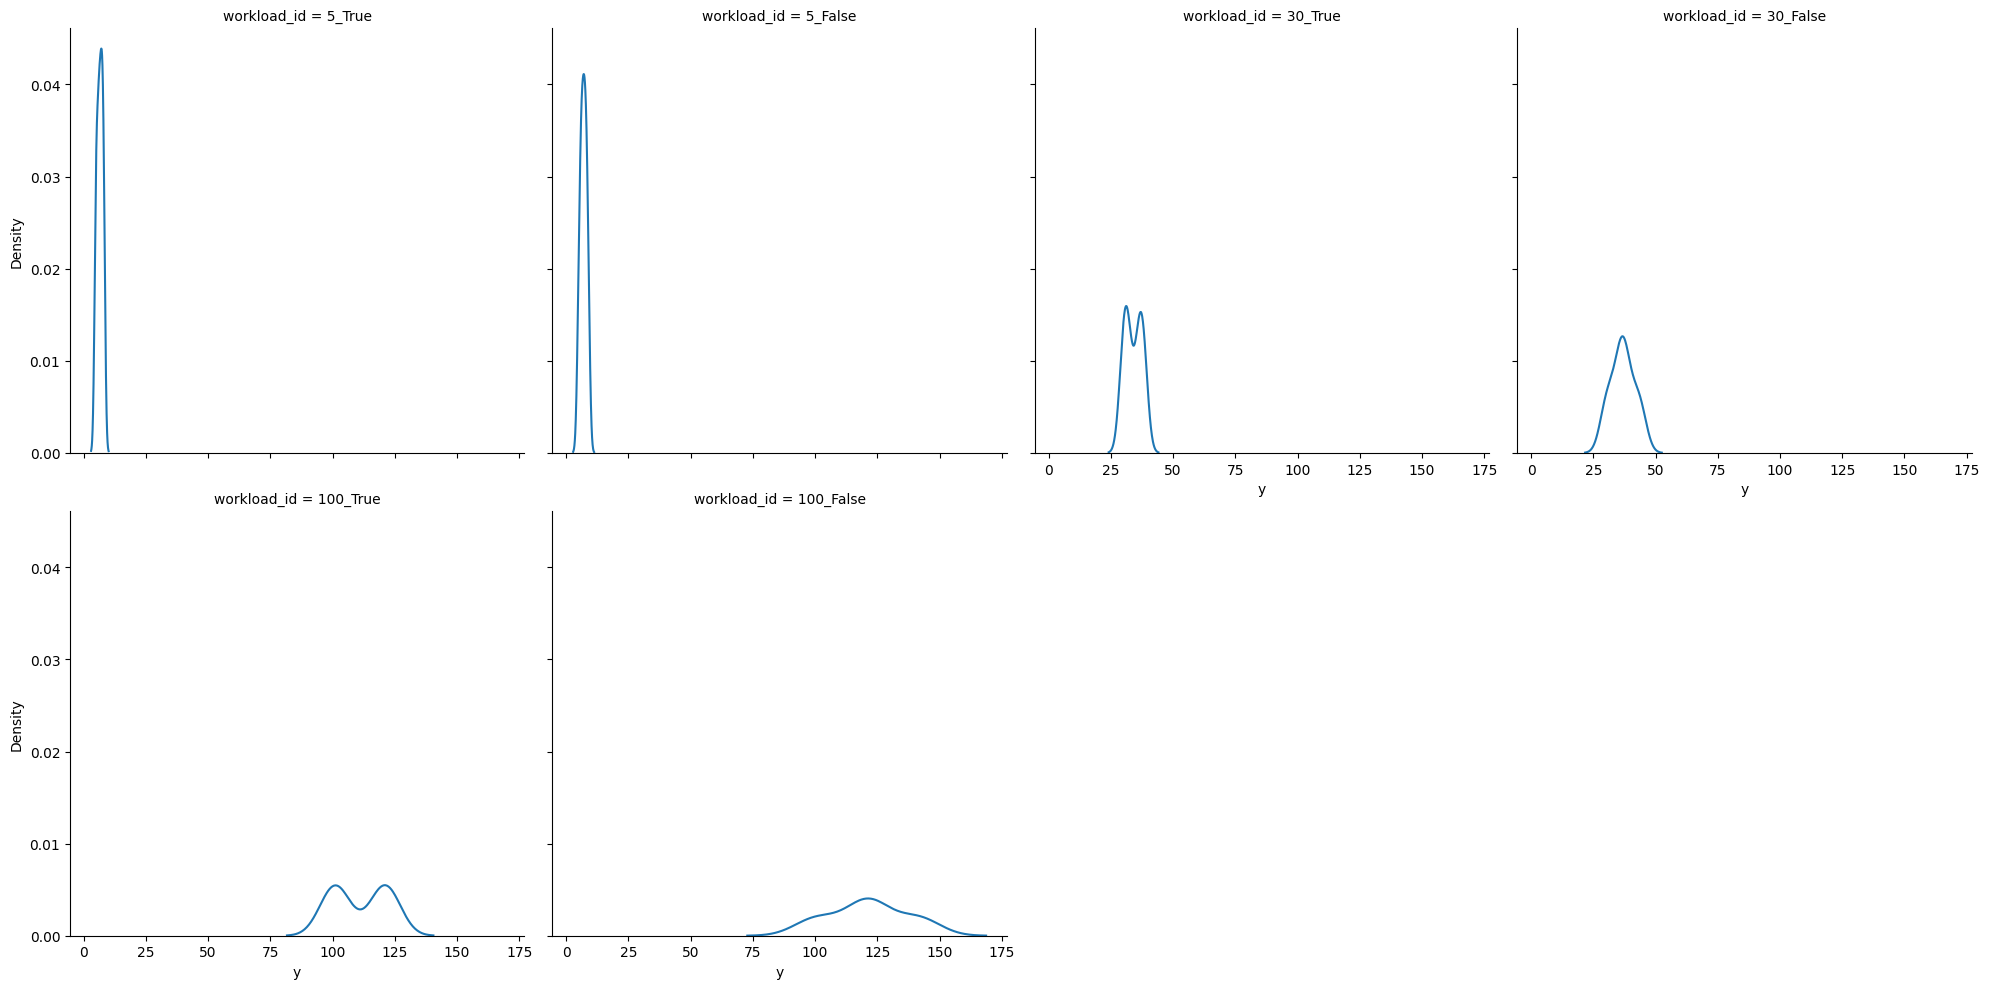

In [ ]:
sns.displot(data=pop_df, x="y", kind="kde", col="workload_id", col_wrap=4)

# Data Pre-Processing

## To normalize or not to normalize

Idea (von Stefan): normalize training data within a given workload to account for linear transfer

Disadvantage: standardized constant influences become smaller the higher the performance mean of a workload gets

In [ ]:
train_ratio = 0.2
# train_ratio = 0.90
data_provider = DfDataProvider("artificial", pop_df, train_ratio=train_ratio, stratify_by_wl=True)
standardizer = StandardizerByTrainSet(data_provider)
train_df = standardizer.get_train_data()

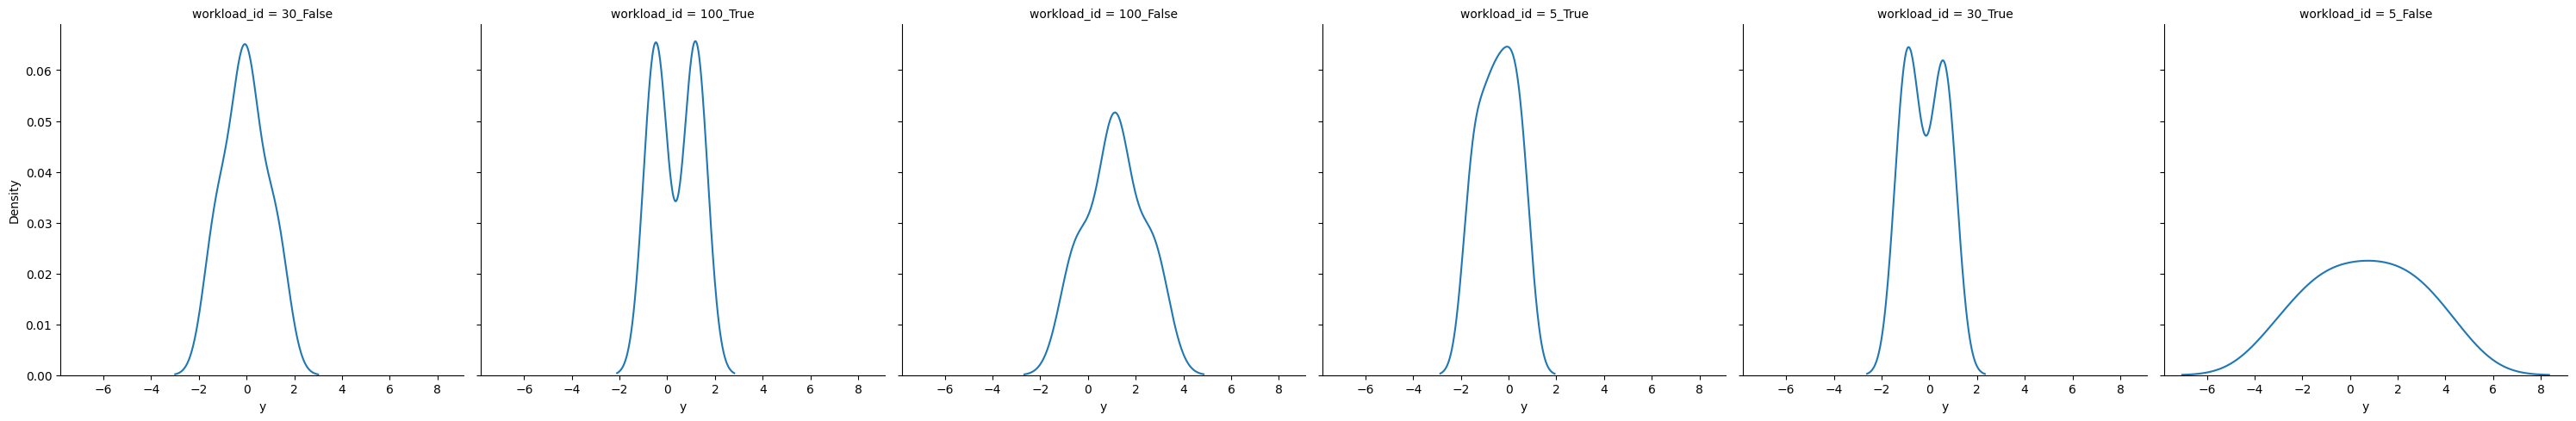

In [ ]:
sns.displot(data=standardizer.data, x="y", kind="kde", col="workload_id", )

# Models

## Overview
1. complete pooling
2. no pooling
3. partial pooling

## Complete Pooling aka P4

```
with numpyro.plate("options", num_opts):
    rnd_influences = numpyro.sample("influences", self.prior_method_call(0, stddev), )

base = numpyro.sample("base", self.prior_method_call(0, stddev))
result_arr = jnp.multiply(data, rnd_influences)
result_arr = result_arr.sum(axis=1).ravel() + base
error_var = numpyro.sample("error", npdist.Exponential(1.0))

with numpyro.plate("data", result_arr.shape[0]):
    obs = numpyro.sample("observations", npdist.Normal(result_arr, error_var), obs=reference_y)
```            

INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-02-14 14:25:34.041 INFO    jax._src.lib.xla_bridge: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-02-14 14:25:34.042 INFO    jax._src.lib.xla_bridge: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-02-14 14:25:34.044 INFO    jax._src.lib.xla_bridge: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
202

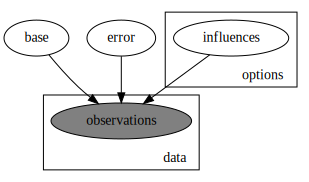

In [ ]:
get_plot_method(CompletePoolingModel(), standardizer.data)()

## No Pooling aka For w in workloads: do P4

```
with numpyro.plate("options", num_opts):
    with numpyro.plate("workloads", n_workloads):
        rnd_influences = numpyro.sample("influences", self.prior_method_call(0, stddev), )

with numpyro.plate("workloads", n_workloads):
    bases = numpyro.sample("base", self.prior_method_call(0, stddev))

respective_influences = rnd_influences[workloads]
respective_bases = bases[workloads]
result_arr = jnp.multiply(data, respective_influences)
result_arr = result_arr.sum(axis=1).ravel() + respective_bases
error_var = numpyro.sample("error", npdist.Exponential(1.0))

with numpyro.plate("data", result_arr.shape[0]):
    obs = numpyro.sample("observations", npdist.Normal(result_arr, error_var), obs=reference_y)
```            

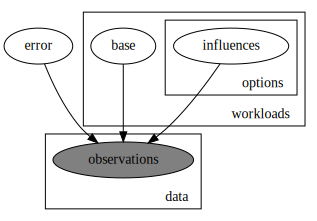

In [ ]:
get_plot_method(NoPoolingModel(), standardizer.data)()

## Partial Pooling aka Multilevel Models

```
with numpyro.plate("options", num_opts):
    hyper_coef_means = numpyro.sample("options-means-hyper", npdist.Laplace(0, stddev), )
    hyper_coef_stddevs = numpyro.sample("options-stddevs-hyper", npdist.Exponential(stddev), )

hyper_base_mean = numpyro.sample("base mean hyperior", npdist.Laplace(0, stddev), )
hyper_base_stddev = numpyro.sample("base stddevs hyperior", npdist.Exponential(stddev), )

with numpyro.plate("options", num_opts):
    with numpyro.plate("workloads", n_workloads):
        rnd_influences = numpyro.sample("influences", npdist.Normal(hyper_coef_means, hyper_coef_stddevs), )

with numpyro.plate("workloads", n_workloads):
    bases = numpyro.sample("base", npdist.Normal(hyper_base_mean, hyper_base_stddev))

respective_influences = rnd_influences[workloads]
respective_bases = bases[workloads]
result_arr = jnp.multiply(data, respective_influences)
result_arr = result_arr.sum(axis=1).ravel() + respective_bases
prior_error_expt = 1.0
error_var = numpyro.sample("error", npdist.Exponential(prior_error_expt))

with numpyro.plate("data", result_arr.shape[0]):
    obs = numpyro.sample("observations", npdist.Normal(result_arr, error_var), obs=reference_y)
```            

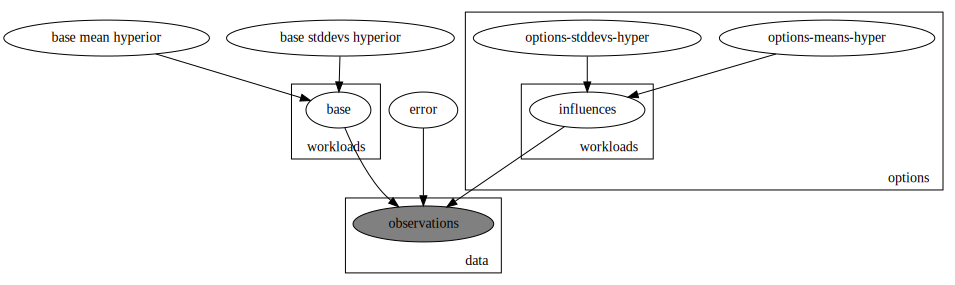

In [ ]:
get_plot_method(MultilevelLassoModel(), standardizer.data)()

# Application

In [ ]:
rnd = 0

## Complete Pooling

In [25]:
%%capture
complete_pooling_model = CompletePoolingModel()
complete_pooling_fitter = ModelFitter(complete_pooling_model)
complete_pooling_fitter.fit(train_df, rnd=rnd)

In [26]:
cpooling_az_d = complete_pooling_fitter.get_arviz_data()
cpooling_az_d

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

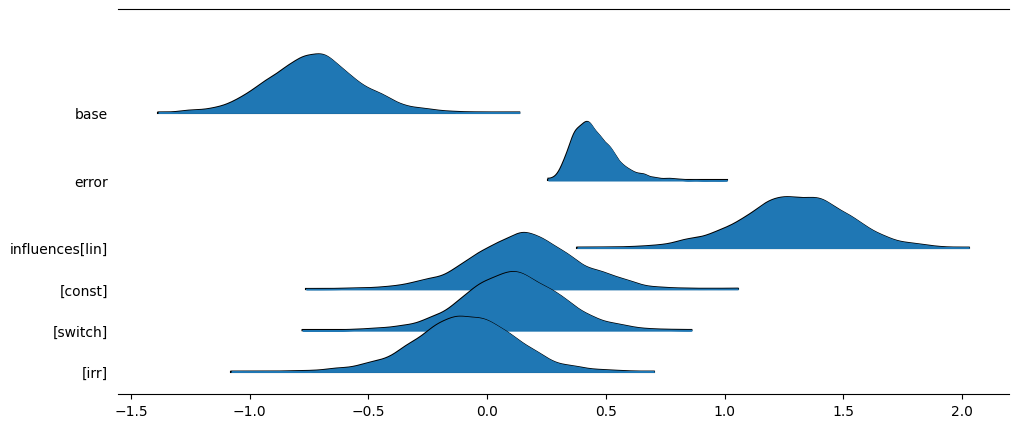

In [27]:
axes = az.plot_forest(
    cpooling_az_d,
    kind="ridgeplot",
    combined=True,
    ridgeplot_overlap=1.75,
    figsize=(11.5, 5),
    hdi_prob=0.9999,
)
plt.show()

In [28]:
az.loo(cpooling_az_d)

Computed from 4500 posterior samples and 19 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -14.41     2.74
p_loo        4.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       16   84.2%
 (0.5, 0.7]   (ok)          3   15.8%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [29]:
posterior_predictive_likelihoods = az.loo(cpooling_az_d, pointwise=True).loo_i

### Investigating surprising samples

-0.7584442339445415

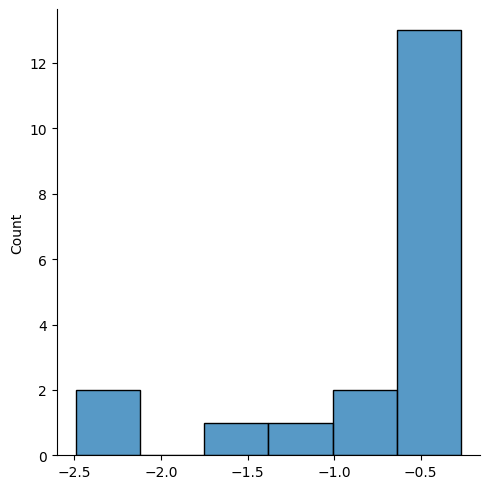

In [30]:
sns.displot(posterior_predictive_likelihoods)
complete_pooling_avg_lh = np.average(posterior_predictive_likelihoods)
complete_pooling_avg_lh

In [31]:
top_most_surprising_idx = np.argsort(list(posterior_predictive_likelihoods))[:5]
surprise_df = deepcopy(train_df)
surprise_df["likelihood"] = posterior_predictive_likelihoods
train_df.iloc[top_most_surprising_idx]

,lin,const,switch,irr,workload_id,y
51,0,1,1,1,30_False,0.124888
90,0,0,0,0,5_True,-1.498098
46,1,0,0,0,100_True,1.154082
69,0,1,0,0,30_False,-1.056578
73,0,0,1,1,5_False,-1.153724


In [32]:
def get_surprise_df(likelihoods, base_df):
    surprise_df = deepcopy(base_df)
    surprise_df["likelihood"] = likelihoods
    return surprise_df
surprise_df = get_surprise_df(posterior_predictive_likelihoods, train_df)
surprise_df.corr()

,lin,const,switch,irr,y,likelihood
lin,1.000000,0.287527,0.168550,-0.258443,0.894134,0.331980
const,0.287527,1.000000,0.011631,0.011631,0.329941,-0.183917
switch,0.168550,0.011631,1.000000,0.136364,0.201757,0.032296
irr,-0.258443,0.011631,0.136364,1.000000,-0.239198,0.021100
y,0.894134,0.329941,0.201757,-0.239198,1.000000,0.218685
likelihood,0.331980,-0.183917,0.032296,0.021100,0.218685,1.000000


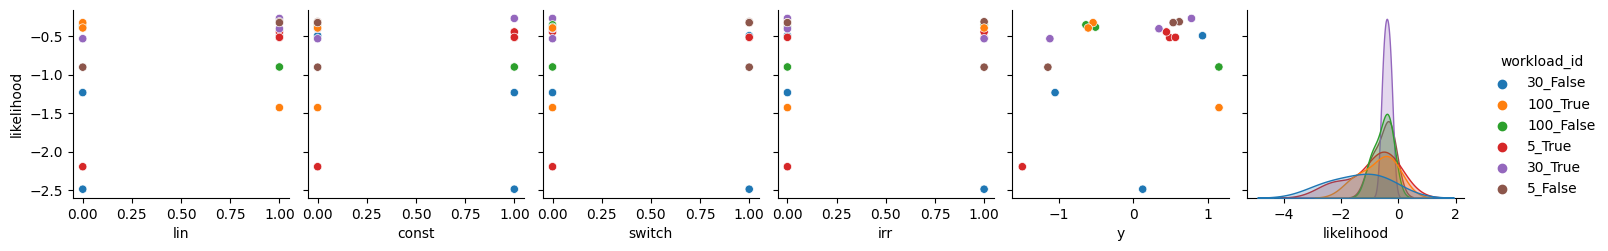

In [33]:
sns.pairplot(data=surprise_df, hue="workload_id", y_vars=["likelihood"])

## No Pooling

In [34]:
%%capture
nopool_model = NoPoolingModel()
no_pool_fitter = ModelFitter(nopool_model)
no_pool_fitter.fit(train_df, rnd=rnd)

In [35]:
nopooling_az = no_pool_fitter.get_arviz_data()
nopooling_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

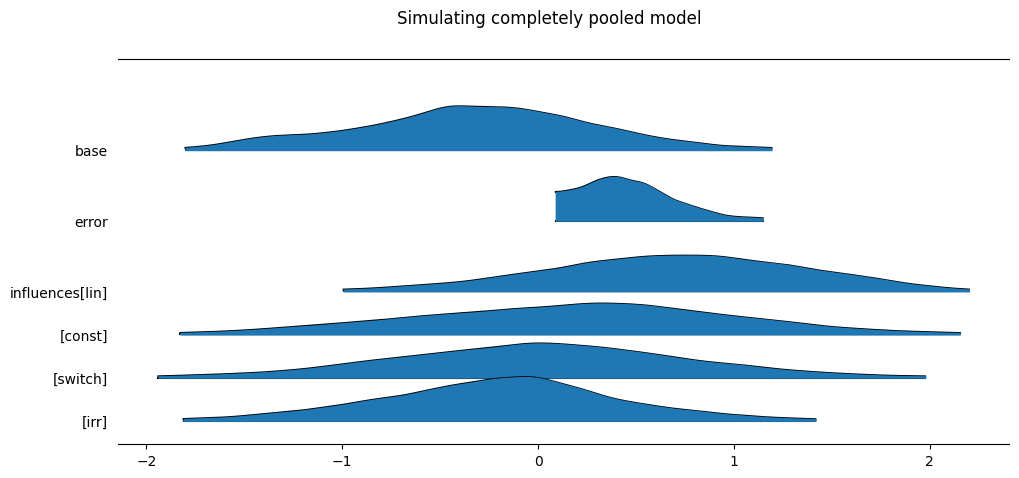

In [36]:
az.plot_forest(nopooling_az, combined=True, combine_dims={"workloads"},
               var_names=["base", "error", "influences"], kind="ridgeplot", ridgeplot_overlap=1.25, hdi_prob=0.99,
               figsize=(11.5, 5), )
plt.suptitle("Simulating completely pooled model")
plt.show()

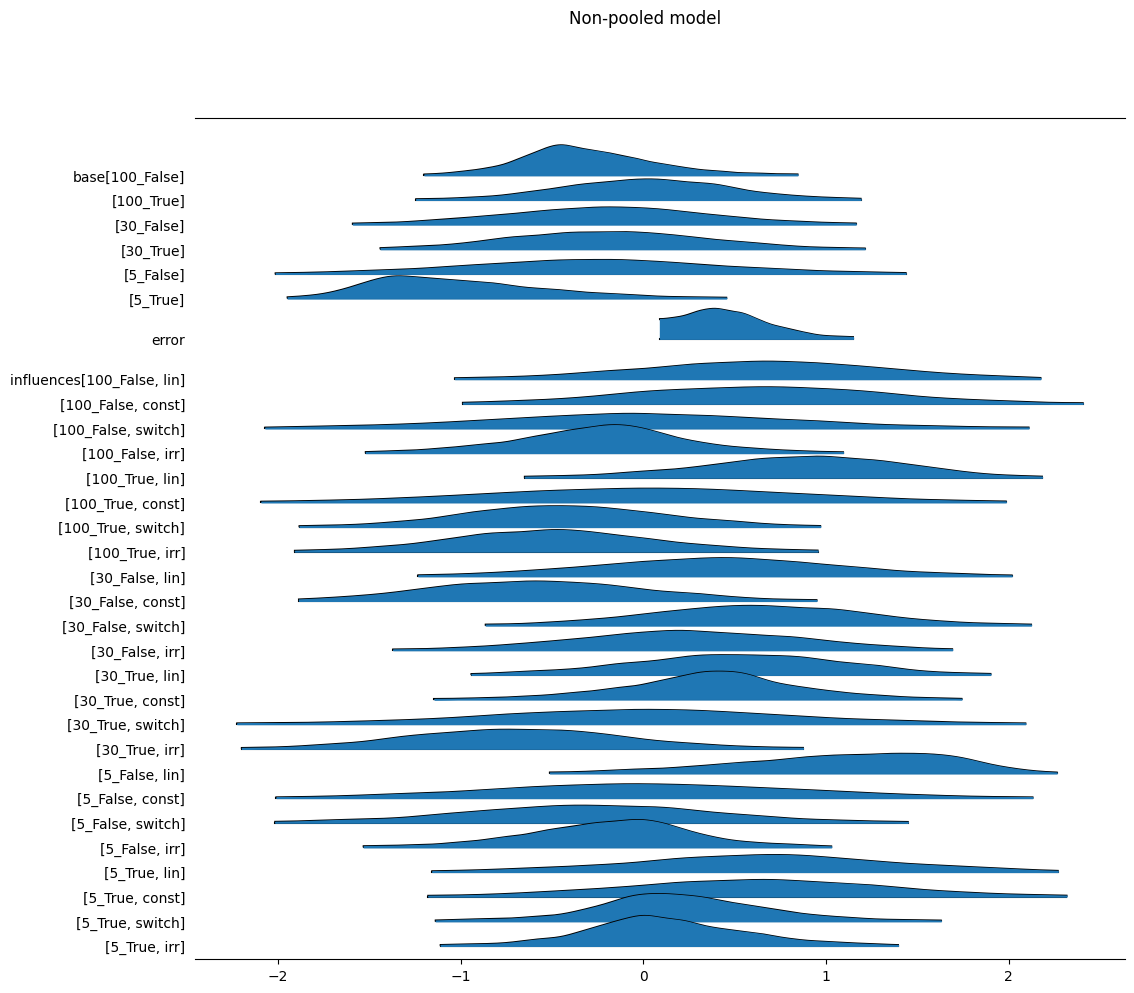

In [37]:
az.plot_forest(nopooling_az, combined=True,
               var_names=["base", "error", "influences"], hdi_prob=0.99, #figsize=(11.5, 7),
               kind="ridgeplot", ridgeplot_overlap=1.5,
               )
plt.suptitle("Non-pooled model");plt.show()

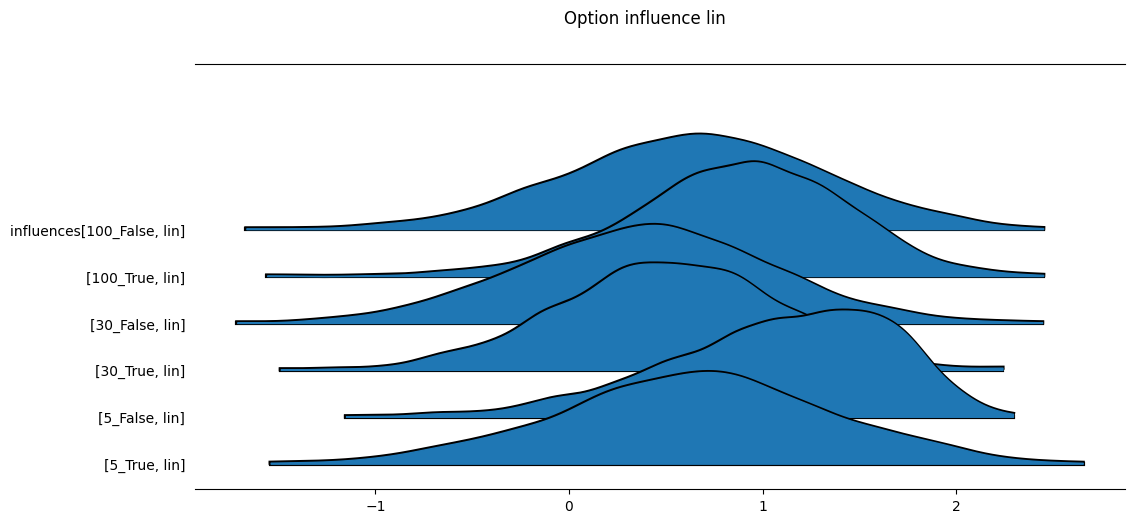

In [38]:
def plot_feature_focus(feature_name: str, az_data, model_names=None, var_names=None):
    var_names = var_names if var_names is not None else ["options-means-hyper", "influences", ]
    coords = {"features": [feature_name]}
    az.plot_forest(az_data, combined=True,
                   var_names=var_names,
                   model_names=model_names,
                   kind="ridgeplot",
                   hdi_prob=0.999,
                   ridgeplot_overlap=3,
                   linewidth=3,
                   coords=coords)
    plt.suptitle(f"Option influence {feature_name}")
    plt.show()

plot_feature_focus("lin", nopooling_az, var_names=["influences"])

In [39]:
az.loo(nopooling_az)

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4500 posterior samples and 19 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -20.79     1.75
p_loo       17.13        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    5.3%
 (0.5, 0.7]   (ok)          6   31.6%
   (0.7, 1]   (bad)        11   57.9%
   (1, Inf)   (very bad)    1    5.3%

In [40]:
nopooling_posterior_predictive_likelihoods = az.loo(nopooling_az, pointwise=True).loo_i
nopooling_surprise_df = get_surprise_df(nopooling_posterior_predictive_likelihoods, train_df)
nopooling_surprise_df.corr()

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,lin,const,switch,irr,y,likelihood
lin,1.000000,0.287527,0.168550,-0.258443,0.894134,0.379564
const,0.287527,1.000000,0.011631,0.011631,0.329941,0.295149
switch,0.168550,0.011631,1.000000,0.136364,0.201757,0.109455
irr,-0.258443,0.011631,0.136364,1.000000,-0.239198,-0.139748
y,0.894134,0.329941,0.201757,-0.239198,1.000000,0.510931
likelihood,0.379564,0.295149,0.109455,-0.139748,0.510931,1.000000


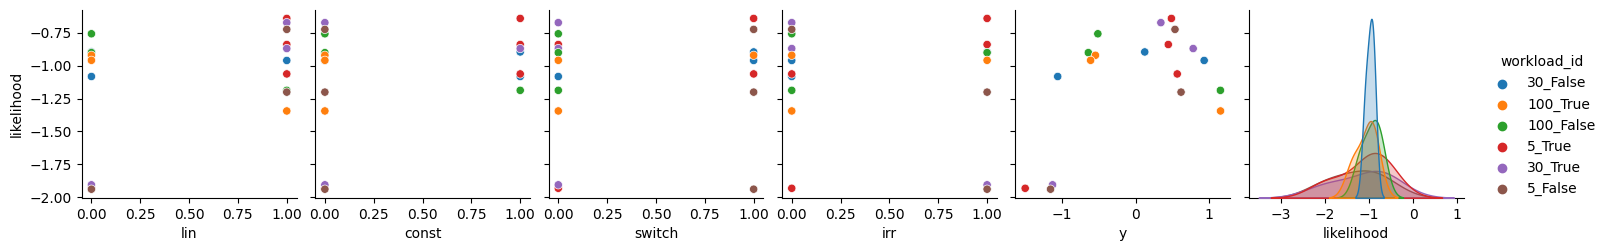

In [41]:
sns.pairplot(data=nopooling_surprise_df, hue="workload_id", y_vars=["likelihood"])

## Partial Pooling

In [42]:
%%capture
multilevel_model = MultilevelLassoModel()
multilevel_fitter = ModelFitter(multilevel_model)
multilevel_fitter.fit(train_df, rnd=rnd)

In [43]:
multilevel_az = multilevel_fitter.get_arviz_data()
multilevel_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

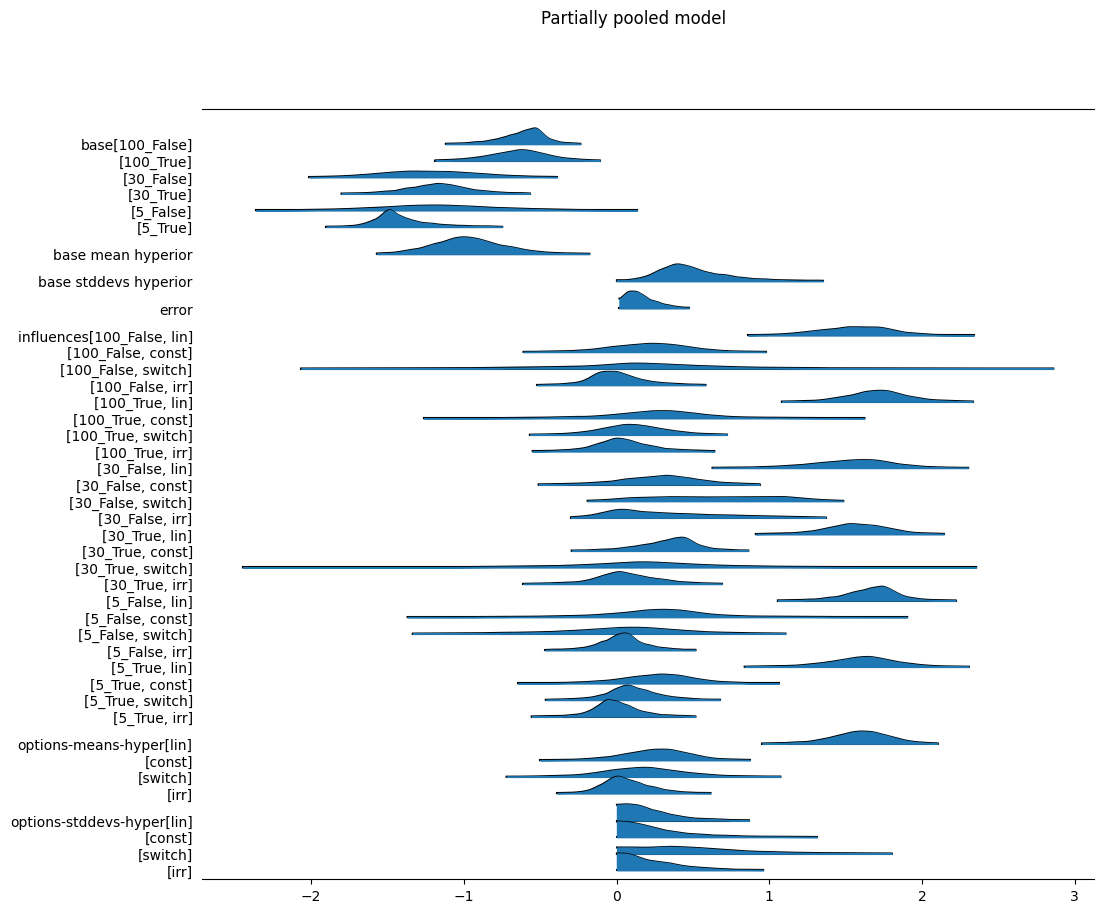

In [44]:
az.plot_forest(multilevel_az, combined=True,  #combine_dims={"workloads"},
               var_names=["~influences_decentered", "~base_decentered"],
               kind="ridgeplot", ridgeplot_overlap=1.25,
               hdi_prob=0.99, figsize=(11.5, 10),
               )
plt.suptitle("Partially pooled model")
plt.show()

### Option Detailed Plot

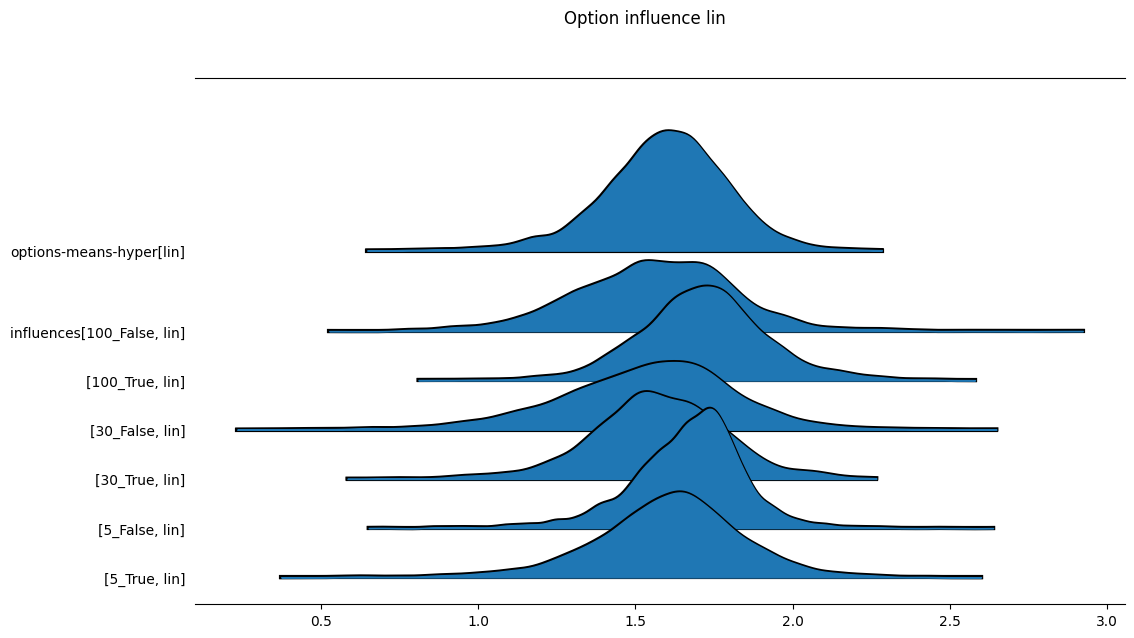

In [45]:
plot_feature_focus("lin", multilevel_az)

## Analysis

In [46]:
az.loo(multilevel_az)

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4500 posterior samples and 19 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    -0.57     1.46
p_loo       19.79        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          1    5.3%
   (0.7, 1]   (bad)        18   94.7%
   (1, Inf)   (very bad)    0    0.0%

In [47]:
multilevel_posterior_predictive_likelihoods = az.loo(multilevel_az, pointwise=True).loo_i
multilevel_surprise_df = get_surprise_df(multilevel_posterior_predictive_likelihoods, train_df)
nopooling_surprise_df.corr()

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,lin,const,switch,irr,y,likelihood
lin,1.000000,0.287527,0.168550,-0.258443,0.894134,0.379564
const,0.287527,1.000000,0.011631,0.011631,0.329941,0.295149
switch,0.168550,0.011631,1.000000,0.136364,0.201757,0.109455
irr,-0.258443,0.011631,0.136364,1.000000,-0.239198,-0.139748
y,0.894134,0.329941,0.201757,-0.239198,1.000000,0.510931
likelihood,0.379564,0.295149,0.109455,-0.139748,0.510931,1.000000


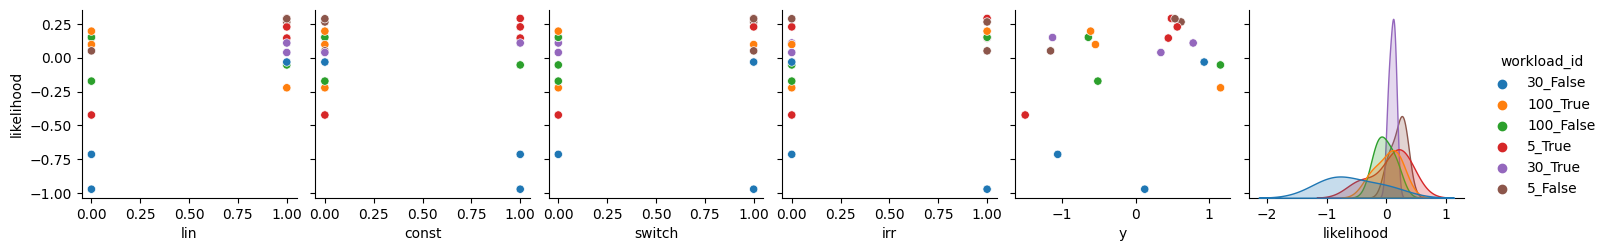

In [48]:
sns.pairplot(data=multilevel_surprise_df, hue="workload_id", y_vars=["likelihood"])

## Comparison

In [49]:
models_az = [cpooling_az_d, nopooling_az, multilevel_az]
models_names = ["pooled", "unpooled", "multilevel"]

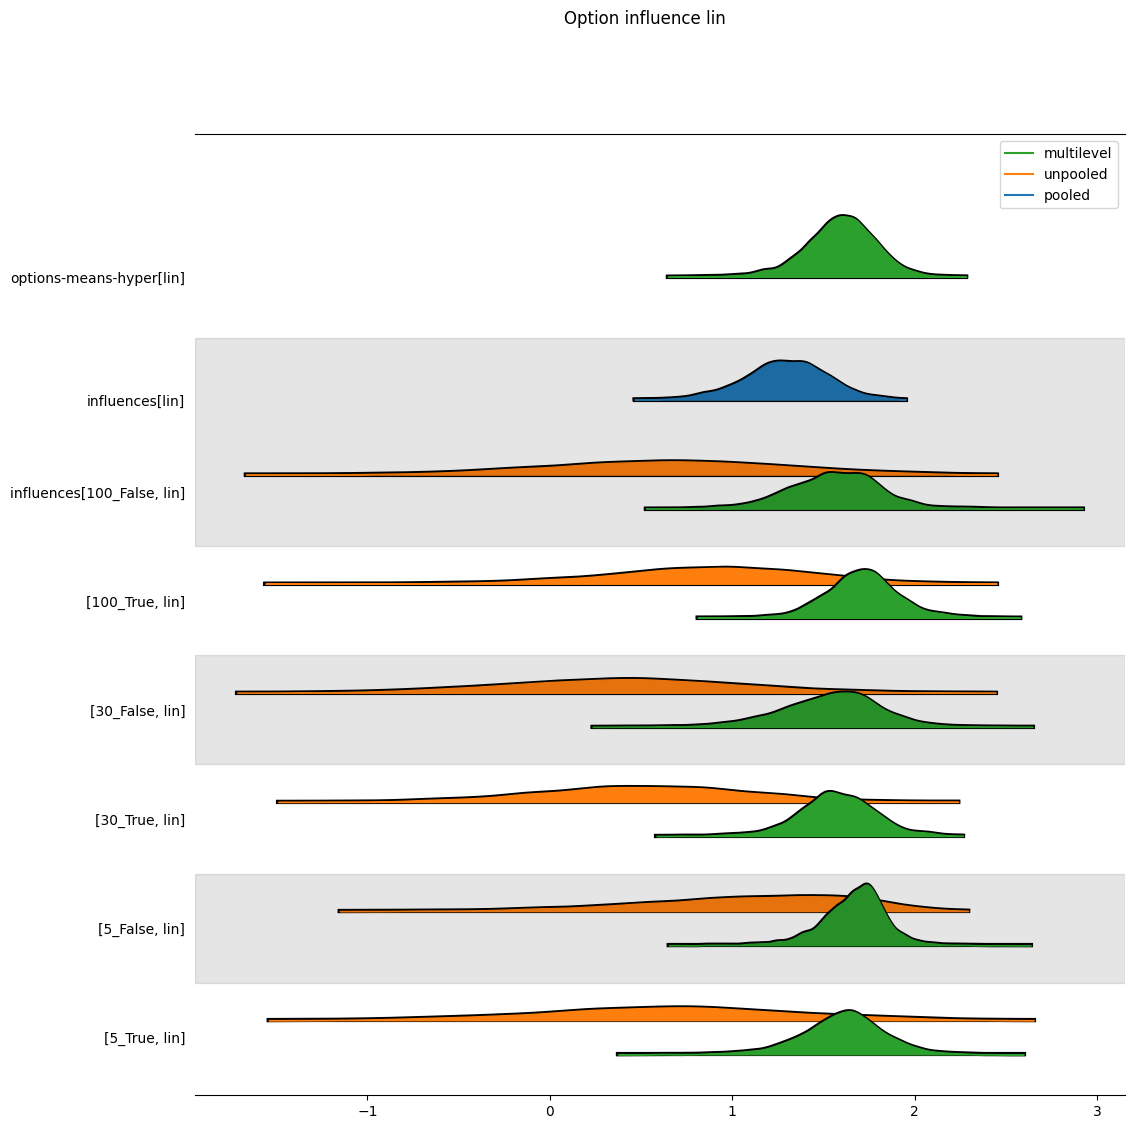

In [50]:
plot_feature_focus("lin", models_az, models_names)

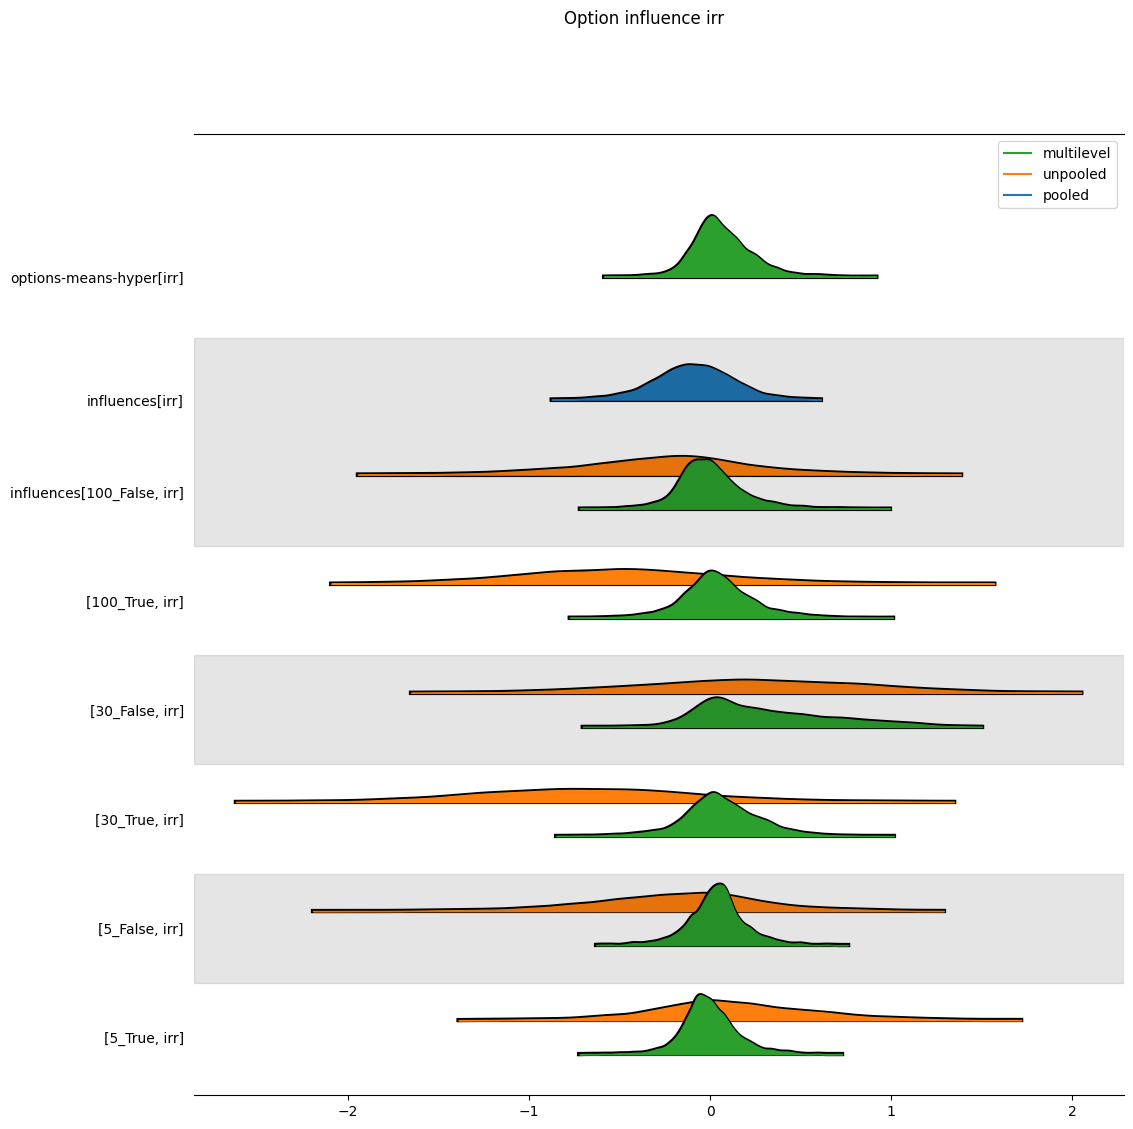

In [51]:
plot_feature_focus("irr", models_az, models_names)

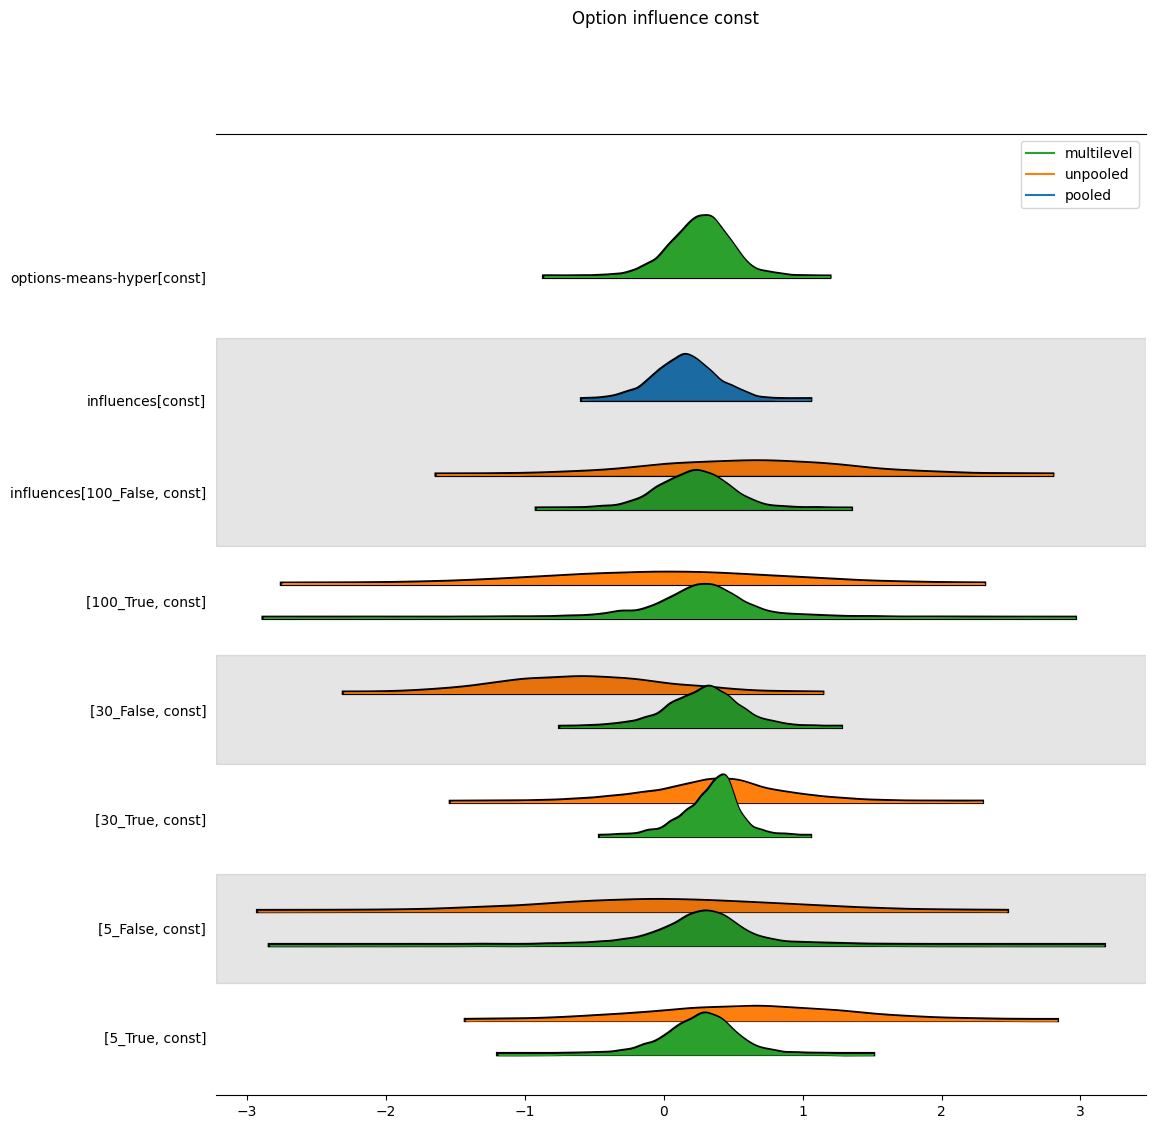

In [52]:
plot_feature_focus("const", models_az, models_names)

In [53]:
az.compare(dict(zip(models_names, models_az)))

/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/jdorn/code/workload-uncertainty-learning/wluncert/jupyer-venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observa

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multilevel,0,-0.567287,19.789371,0.000000,1.000000e+00,1.455105,0.000000,True,log
pooled,1,-14.410440,4.943111,13.843153,0.000000e+00,2.739451,1.682173,False,log
unpooled,2,-20.788088,17.128319,20.220800,2.603029e-12,1.747062,2.111957,True,log
